In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from yahoofinancials import YahooFinancials as yf

In [2]:
tickers = ['GOLD', '^TNX', '^IRX', '^GSPC']
bonds = ['^TNX', '^IRX']
expl = {'GOLD': 'Gold', '^TNX': '10YR bond', '^IRX': 'Cash', '^GSPC': 'S&P 500',
       '^FTSE': 'UK 100', '^RUT': 'Small-Cap index', '^DJI': 'Dow Jones'}
YF = yf(tickers)

In [3]:
start = '1900-01-01'
end = '2100-01-01'
data = YF.get_historical_price_data(start, end, 'daily')
data = {key:value['prices'] for key, value in data.items()}

In [4]:
alltime_prices = {ticker: np.array([price['close'] for price in prices]) for ticker, prices in data.items()}
dates = {ticker: np.array([price['date'] for price in prices]) for ticker, prices in data.items()}
formatted_dates = {ticker: np.array([price['formatted_date'] for price in prices]) for ticker, prices in data.items()}
first_date = np.max([date[0] for date in dates.values()])
first_ticker = tickers[np.argmax([date[0] for date in dates.values()])]
print(first_ticker, first_date/(60*60*24*365.25)+1970)

GOLD 1985.095425507643


In [5]:
idxs = {ticker: np.array([np.abs(date - d).argmin() for d in dates[first_ticker]]) for ticker, date in dates.items()}

In [6]:
prices = {}
for ticker in tickers:
    p = alltime_prices[ticker][idxs[ticker]]
    noneidx = np.where(p == None)[0]
    for idx in noneidx:
        p[idx] = p[idx-1]
    prices[ticker] = p.astype(np.float64)

In [7]:
# returns per year
rpy = {ticker: (price[252:] / price[:-252]) for ticker, price in prices.items()} 
for ticker in bonds:
    rpy[ticker] = prices[ticker][:-252]/100 + 1

In [8]:
rets = np.array([ret.tolist() for ret in rpy.values()])

In [9]:
means = rets.mean(axis=1)
stds = rets.std(axis=1)
sigma = np.cov(rets)

print(means)
print(stds)

[1.18792944 1.05180172 1.03304972 1.09715767]
[0.55363454 0.02338188 0.02553687 0.15872548]


In [10]:
def cost(m):
    def f(x):
        return -m@x
    return f

def newstd(s):
    def f(x):
        return np.sqrt(x@sigma@x)
    return f
x = np.ones(len(means))/len(means)
print(x)

[0.25 0.25 0.25 0.25]


In [11]:
maxstds = [0.025, 0.05, 0.075, 0.10, 0.125, 0.15]
opt_means = []
for maxstd in maxstds:

    # Lineear equality constraints
    A = np.eye(len(means))
    lb = np.zeros(len(means))
    ub = np.ones(len(means))*np.inf
    LEC = optimize.LinearConstraint(A, lb, ub)
    
    # Linear inequality constraints
    LIC = optimize.LinearConstraint(np.ones(len(means)), 1.0, 1.0)
    
    # Nonlinear constraints
    NLC = optimize.NonlinearConstraint(newstd(sigma), maxstd, maxstd)

    res = optimize.minimize(cost(means), x, constraints=[LEC, LIC, NLC])

    opt_means.append(-res['fun'])
    
    print('Optimal portfolio with a maximum standard deviation: {} %'.format(maxstd*100))
    print('Return of {:.2f} % per year'.format(-res['fun']/res['x'].sum()*100-100))
    print()
    for i, ticker in enumerate(tickers):
        print('{}: {:.2f} %'.format(expl[ticker], res['x'][i]*100))
    print()
    print()

Optimal portfolio with a maximum standard deviation: 2.5 %
Return of 5.46 % per year

Gold: -0.00 %
10YR bond: 93.84 %
Cash: -0.00 %
S&P 500: 6.16 %


Optimal portfolio with a maximum standard deviation: 5.0 %
Return of 6.65 % per year

Gold: 3.55 %
10YR bond: 74.72 %
Cash: 0.00 %
S&P 500: 21.73 %


Optimal portfolio with a maximum standard deviation: 7.5 %
Return of 7.61 % per year

Gold: 6.51 %
10YR bond: 59.46 %
Cash: -0.00 %
S&P 500: 34.03 %


Optimal portfolio with a maximum standard deviation: 10.0 %
Return of 8.54 % per year

Gold: 9.40 %
10YR bond: 44.81 %
Cash: 0.00 %
S&P 500: 45.79 %


Optimal portfolio with a maximum standard deviation: 12.5 %
Return of 9.45 % per year

Gold: 12.18 %
10YR bond: 30.23 %
Cash: 0.00 %
S&P 500: 57.59 %


Optimal portfolio with a maximum standard deviation: 15.0 %
Return of 10.36 % per year

Gold: 14.98 %
10YR bond: 15.83 %
Cash: -0.00 %
S&P 500: 69.19 %




In [12]:
np.corrcoef(rets)

array([[1.        , 0.35424079, 0.31209935, 0.17758021],
       [0.35424079, 1.        , 0.90851091, 0.11148815],
       [0.31209935, 0.90851091, 1.        , 0.07032677],
       [0.17758021, 0.11148815, 0.07032677, 1.        ]])

(array([0.00069946, 0.0010492 , 0.00186524, 0.00373047, 0.00594544,
        0.00454651, 0.00186524, 0.00338074, 0.00279785, 0.00419678,
        0.00804383, 0.0153882 , 0.01305666, 0.01235719, 0.01340639,
        0.01573793, 0.01597109, 0.02296573, 0.01632082, 0.0179529 ,
        0.03170902, 0.04301702, 0.05141059, 0.06773141, 0.07344369,
        0.08230357, 0.07997202, 0.06050361, 0.05863838, 0.05514106,
        0.05059454, 0.03975286, 0.03777104, 0.02518069, 0.02203311,
        0.0128235 , 0.00839356, 0.00699464, 0.00279785, 0.00314759,
        0.00174866, 0.00174866, 0.00069946, 0.00023315, 0.        ,
        0.00011658, 0.00046631, 0.        , 0.        , 0.00034973]),
 array([0.51177177, 0.53525103, 0.55873028, 0.58220953, 0.60568878,
        0.62916804, 0.65264729, 0.67612654, 0.69960579, 0.72308505,
        0.7465643 , 0.77004355, 0.79352281, 0.81700206, 0.84048131,
        0.86396056, 0.88743982, 0.91091907, 0.93439832, 0.95787758,
        0.98135683, 1.00483608, 1.02831533, 1.

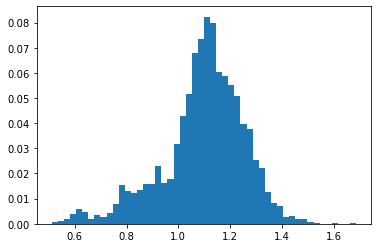

In [27]:
weights = np.ones_like(rets[-1,:])/float(len(rets[-1,:]))
plt.hist(rets[-1,:], bins=50, weights=weights)

In [18]:
rpd = {ticker: (price[1:] / price[:-1]) for ticker, price in prices.items()} 
retd = np.array([ret.tolist() for ret in rpd.values()])

(array([1.13263110e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.13263110e-04,
        2.26526220e-04, 0.00000000e+00, 1.13263110e-04, 0.00000000e+00,
        1.13263110e-04, 0.00000000e+00, 4.53052441e-04, 1.13263110e-04,
        3.39789331e-04, 2.26526220e-04, 0.00000000e+00, 4.53052441e-04,
        5.66315551e-04, 5.66315551e-04, 9.06104882e-04, 1.13263110e-03,
        7.92841771e-04, 2.26526220e-03, 4.19073508e-03, 4.757050

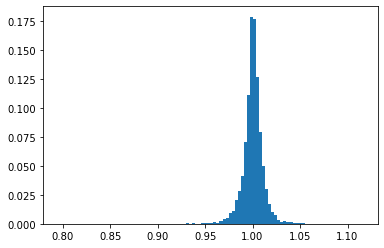

In [36]:
weights = np.ones_like(retd[-1,:])/float(len(retd[-1,:]))
plt.hist(retd[-1,:], bins=100, weights=weights)

In [165]:
def npdf(u, s, N=1000):
    x = ((np.arange(N+1) / N)-0.5)*s*20 + u
    pdf = 1/(s*np.sqrt(2*np.pi))*np.exp(-0.5*((x-u)/s)**2)
    return x, pdf

from scipy.stats import levy_stable

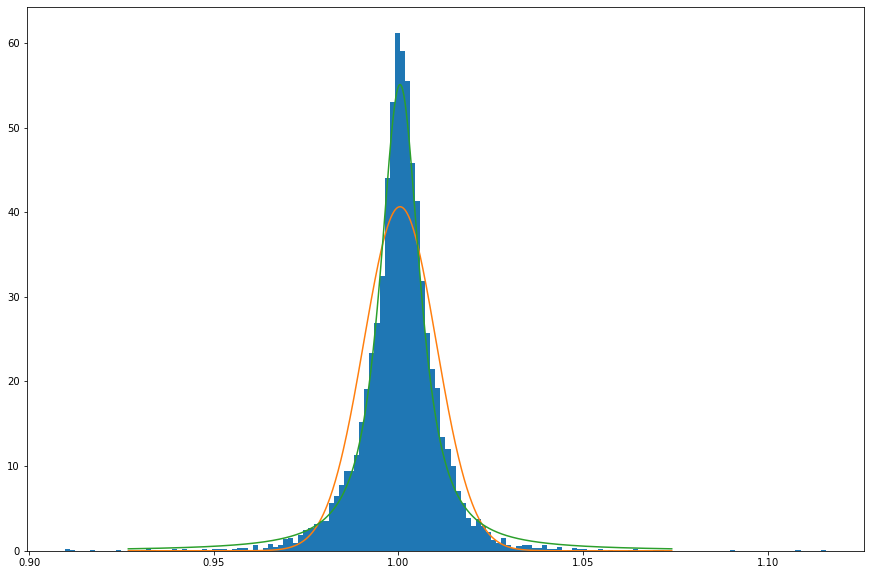

In [290]:
plt.figure(figsize=(15,10))
test = retd[-1, retd[-1,:].argsort()[1:]]
weights = np.ones_like(test)/float(len(test))
plt.hist(test, bins=150, density=True)
u, s = test.mean(), test.std()
x, pdf = npdf(u, s*0.9)
plt.plot(x, pdf)
# alpha = 1.15
# beta = 0.0
# c = 0.0055
lev = levy_stable.pdf(x, alpha, beta, loc=u, scale=c)
plt.plot(x, lev)

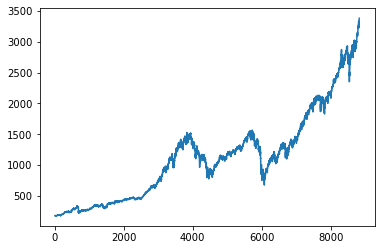

In [16]:
SP500 = prices['^GSPC']
plt.plot(SP500)

In [17]:
(SP500[1:]/SP500[:-1]).mean()

1.0003943042997607